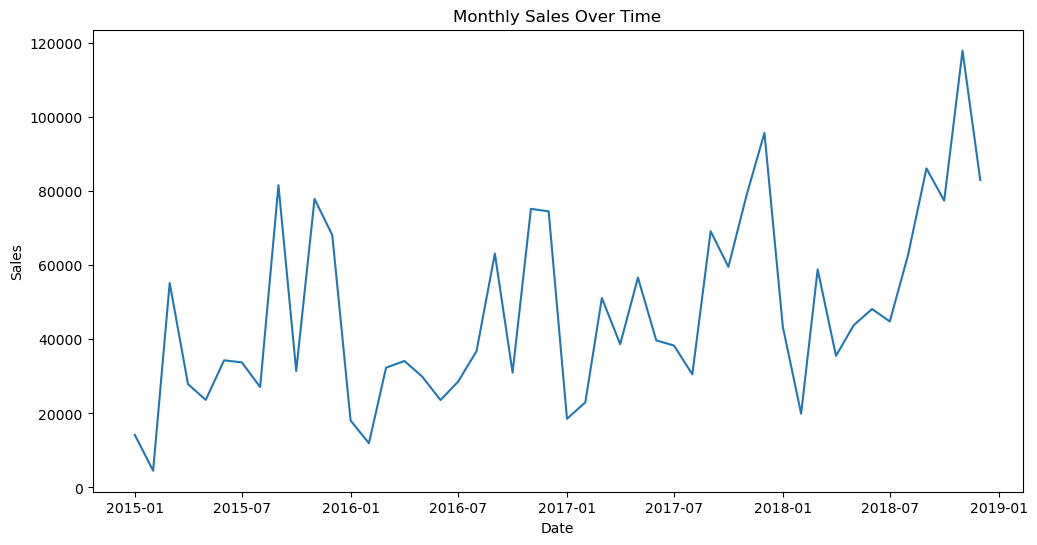

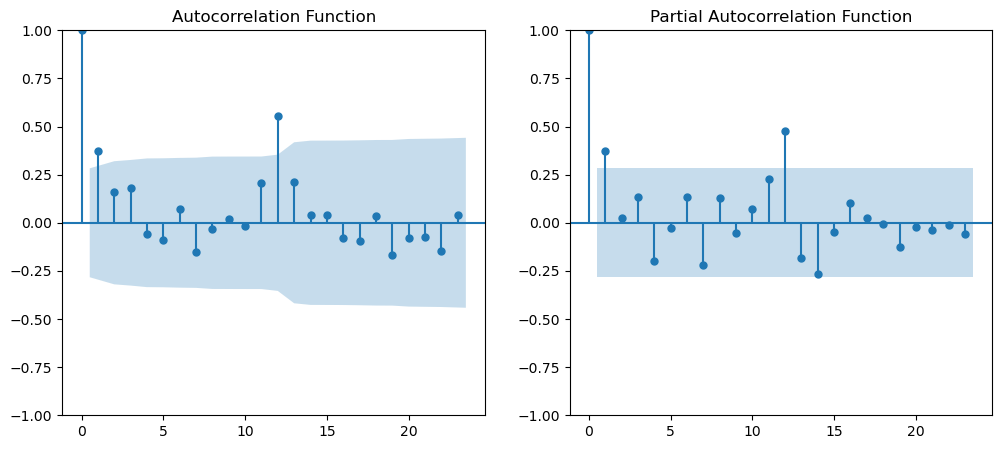

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -539.293
Date:                Fri, 16 May 2025   AIC                           1084.585
Time:                        18:42:04   BIC                           1090.136
Sample:                    01-01-2015   HQIC                          1086.674
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2546      0.265      0.961      0.337      -0.265       0.774
ma.L1         -0.8477      0.144     -5.898      0.000      -1.129      -0.566
sigma2      5.791e+08   8.52e-11   6.79e+18      0.0

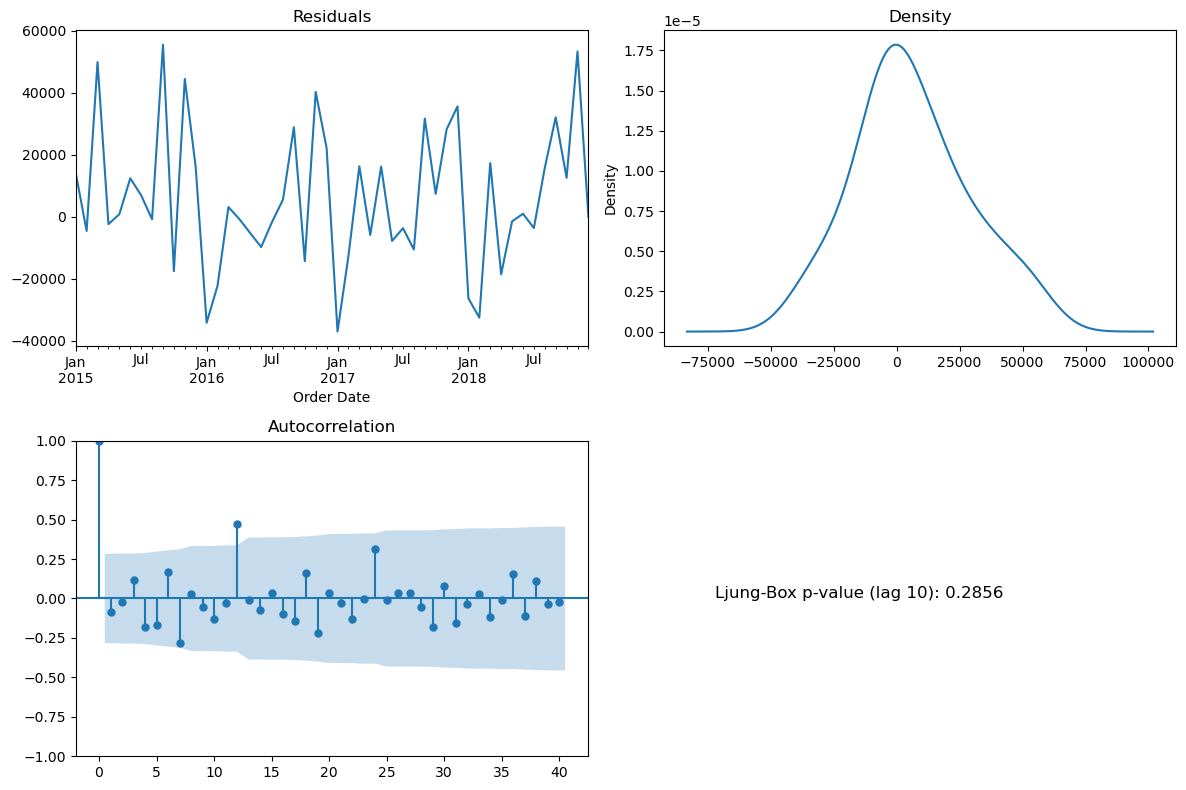

Model saved to ../models/arima_model.pkl
Forecast for next 6 months:
2019-01-01    74121.351834
2019-02-01    71852.991769
2019-03-01    71275.436934
2019-04-01    71128.383741
2019-05-01    71090.942030
2019-06-01    71081.408870
Freq: MS, Name: predicted_mean, dtype: float64


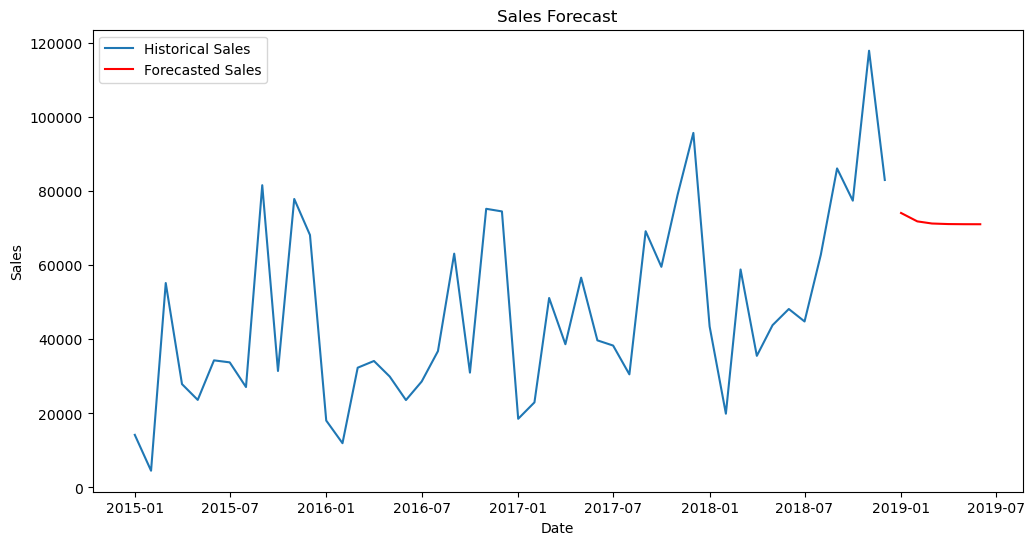

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import pickle
import os

# Load and preprocess data
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)
    df.set_index('Order Date', inplace=True)
    monthly_sales = df['Sales'].resample('MS').sum()
    monthly_sales = monthly_sales.interpolate(method='linear')
    return monthly_sales.to_frame()

# Exploratory data analysis (EDA)
def exploratory_data_analysis(df):
    plt.figure(figsize=(12,6))
    sns.lineplot(x=df.index, y='Sales', data=df)
    plt.title('Monthly Sales Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

# Plot ACF and PACF
def plot_acf_pacf(series, lags=40):
    max_lags = min(lags, len(series)//2 - 1)  # Ensure lags < 50% sample size
    
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plot_acf(series, lags=max_lags, ax=plt.gca())
    plt.title('Autocorrelation Function')
    
    plt.subplot(1, 2, 2)
    plot_pacf(series, lags=max_lags, ax=plt.gca())
    plt.title('Partial Autocorrelation Function')
    
    plt.show()


# Fit ARIMA model
def fit_arima_model(df, order=(1,1,1)):
    model = ARIMA(df['Sales'], order=order)
    model_fit = model.fit()
    print(model_fit.summary())
    return model_fit

# Forecast sales
def forecast_sales(model_fit, steps=6):
    forecast = model_fit.forecast(steps=steps)
    print(f"Forecast for next {steps} months:")
    print(forecast)
    return forecast

# Plot forecast results
def plot_forecast(df, forecast):
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df['Sales'], label='Historical Sales')
    forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=len(forecast), freq='MS')
    plt.plot(forecast_index, forecast, label='Forecasted Sales', color='red')
    plt.title('Sales Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

# ARIMA diagnostics
def arima_diagnostics(model_fit):
    residuals = model_fit.resid

    plt.figure(figsize=(12,8))

    plt.subplot(2,2,1)
    residuals.plot(title="Residuals", ax=plt.gca())

    plt.subplot(2,2,2)
    residuals.plot(kind='kde', title='Density', ax=plt.gca())

    plt.subplot(2,2,3)
    plot_acf(residuals, lags=40, ax=plt.gca())

    plt.subplot(2,2,4)
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    plt.text(0.1, 0.5, f"Ljung-Box p-value (lag 10): {lb_test['lb_pvalue'].values[0]:.4f}", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Save model to disk
def save_model(model_fit, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(model_fit, f)
    print(f"Model saved to {filepath}")

# Load model from disk
def load_model(filepath):
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {filepath}")
    return model

# Main execution
if __name__ == "__main__":
    data_filepath = "../data/train.csv"     # relative path from notebook folder
    model_filepath = "../models/arima_model.pkl"  # path to save/load model
    
    # Make sure models directory exists
    if not os.path.exists("../models"):
        os.makedirs("../models")

    # Load and preprocess data
    sales_data = load_and_preprocess_data(data_filepath)

    # EDA
    exploratory_data_analysis(sales_data)
    plot_acf_pacf(sales_data['Sales'])

    # Fit model
    arima_model = fit_arima_model(sales_data)

    # Diagnostics
    arima_diagnostics(arima_model)

    # Save the model
    save_model(arima_model, model_filepath)

    # Forecast next 6 months
    future_forecast = forecast_sales(arima_model, steps=6)

    # Plot forecast
    plot_forecast(sales_data, future_forecast)
